## Data Analysis

In [109]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
os.listdir('/kaggle/input/BloodPressureDataset')

['part_4.mat',
 'part_9.mat',
 'part_10.mat',
 'Samples',
 'part_11.mat',
 'part_3.mat',
 'part_1.mat',
 'part_8.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_2.mat',
 'part_12.mat']

In [110]:
# defining our evaluation error function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [111]:
sample_file = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')

sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [112]:
# Loading a sample .mat file to understand the data dimensions
test_sample = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [113]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125

print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [114]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

In [115]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [116]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


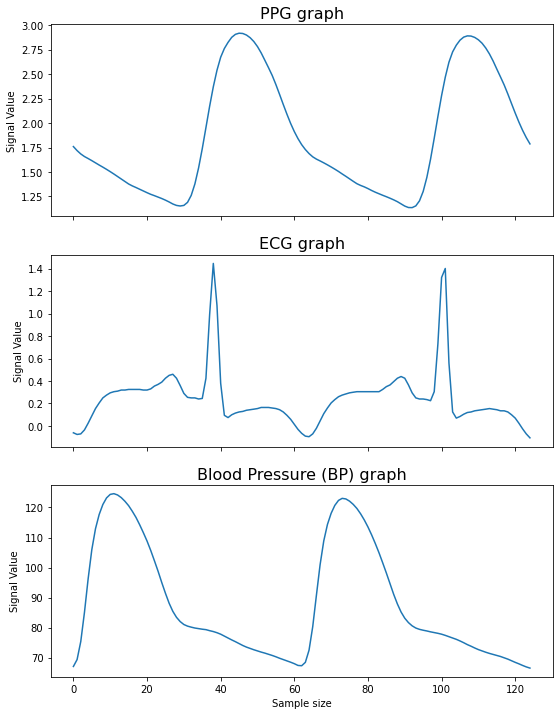

In [117]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

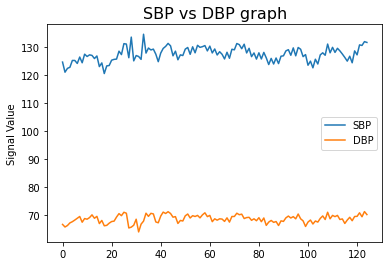

In [118]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

It can be seen from above that `SBP` is higher than `DBP` as was explained [earlier](#sbp_cell)

### Statistical Correlation of signals


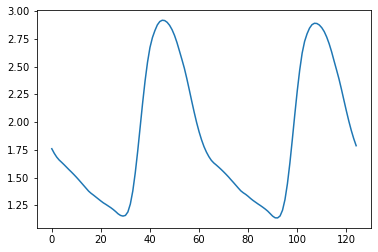

In [119]:
plt.plot(ppg[:125].squeeze())

### Computing and Visualizing the Cross correlation of PPG and BP signals

[Cross correlation](https://en.wikipedia.org/wiki/Cross-correlation#:~:text=In%20signal%20processing%2C%20cross%2Dcorrelation,for%20a%20shorter%2C%20known%20feature.) is where two signals are compared inorder to produce a third signal that shows the similarity between the two signals compared. It can be used to create plots that may reveal hidden sequences.

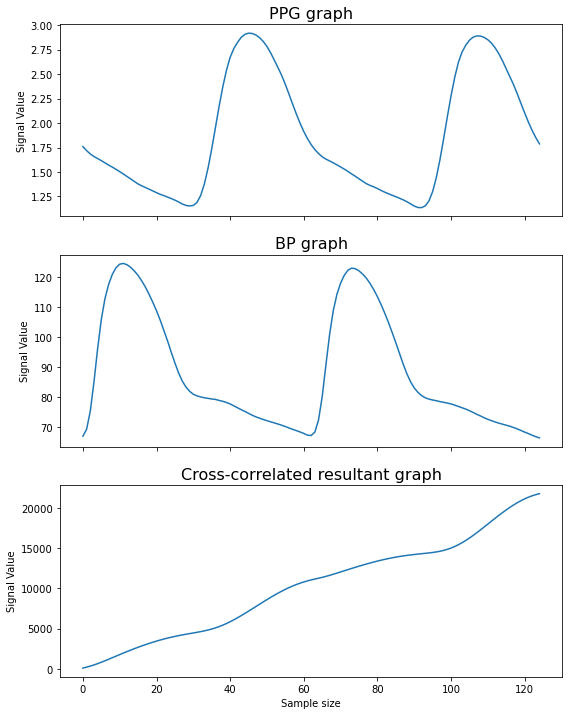

In [120]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

In [121]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(ppg, bp, test_size=0.30)

In [122]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [123]:
def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim = input_dim))

    model.add(Dropout(0.5))

    model.add(Dense(num_class))    
    model.add(Activation('linear'))
    
    model.compile(loss='Huber',
                  optimizer=optimizers.Adam(lr = 0.001),
                  metrics=['MeanAbsoluteError']
                 )
    return model

In [124]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 1025      
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


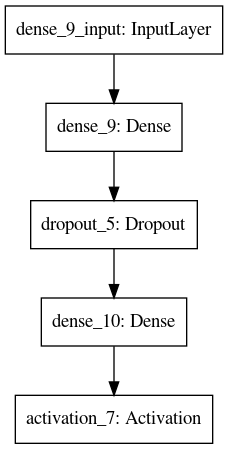

In [125]:
# Visualizing the model
tf.keras.utils.plot_model(model)

In [126]:
# Training the model
history = model.fit(X_train[:1000000], # using the first 1million rows for speed.
                    y_train[:1000000].squeeze(),
                    epochs=50,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/50
7813/7813 [==============================] - 17s 2ms/step - loss: 22.3840 - mean_absolute_error: 22.8791
Epoch 2/50
7813/7813 [==============================] - 16s 2ms/step - loss: 21.3874 - mean_absolute_error: 21.8825
Epoch 3/50
7813/7813 [==============================] - 17s 2ms/step - loss: 21.3814 - mean_absolute_error: 21.8766
Epoch 4/50
7813/7813 [==============================] - 16s 2ms/step - loss: 21.3829 - mean_absolute_error: 21.8780
Epoch 5/50
7813/7813 [==============================] - 17s 2ms/step - loss: 21.3860 - mean_absolute_error: 21.8811
Epoch 6/50
7813/7813 [==============================] - 17s 2ms/step - loss: 21.3841 - mean_absolute_error: 21.8792
Epoch 7/50
7813/7813 [==============================] - 17s 2ms/step - loss: 21.3789 - mean_absolute_error: 21.8740
Epoch 8/50
7813/7813 [==============================] - 17s 2ms/step - loss: 21.3798 - mean_absolute_error: 21.8749
Epoch 9/50
7813/7813 [==============================] - 16s 2ms/step - l

In [127]:
#Predicting on the test set using the nn(neural network) model
nn_predictions = model.predict(X_test[:1000000])
error = rmse(y_test[:1000000], nn_predictions)
print(f'Neural Net RMSE: {error}')

Neural Net RMSE: 28.059138075597453


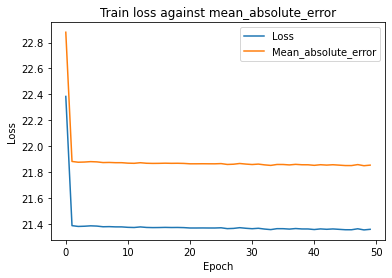

In [128]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

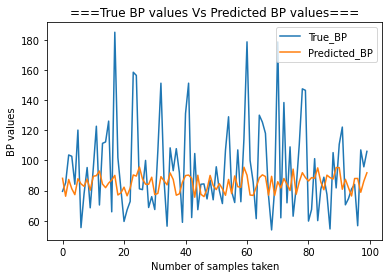

In [129]:
# Visualize predicted BP and the True BP
plt.title("===True BP values Vs Predicted BP values===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[:100]) #only plotting 100 samples
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])